In [1]:
import itertools
from copy import deepcopy, copy

import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
import pandas as pd


from model import BaseModel
from true_causal_model import TrueCausalModel
from agents.causal_agents import HalfBlindAgent

%matplotlib inline
np.random.seed(0)

## Entrada: Orden parcial y aristas inválidas

In [2]:
DG = nx.DiGraph([("Reaccion", "Final"), ("Tratamiento", "Reaccion"), ("Tratamiento", "Final"), ("Enfermedad", "Final")])
causal_order = list(nx.topological_sort(DG))
invalid_edges = sorted([("Enfermedad", "Tratamiento")])
print(causal_order)

['Enfermedad', 'Tratamiento', 'Reaccion', 'Final']


## Genero creencias p<sub>ij</sub> iniciales

In [3]:
def is_a_valid_edge(x, y, causal_order, invalid_edges):
    if tuple(sorted((x, y))) in invalid_edges or causal_order.index(y) < causal_order.index(x):
        return False
    return True

In [4]:
def create_pij(variables, causal_order, invalid_edges):
    connection_tables = dict()
    for pair in itertools.combinations((variables), 2):
        proba = np.random.rand()
        if is_a_valid_edge(pair[0], pair[1], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[0], pair[1])] = proba
        elif is_a_valid_edge(pair[1], pair[0], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[1], pair[0])] = proba
    return connection_tables
def create_ebunch_from_beliefs(variables, connection_tables):
    ebunch = []
    for pair in connection_tables:
        r = np.random.rand()
        if r <= connection_tables[pair]:
            ebunch.append((pair.split('->')[0], pair.split('->')[1]))
    nodes = []
    for v in variables:
        flag = False
        for edge in ebunch:
            if v in edge:
                flag = True
                break
        if not flag:
            nodes.append(v)
    return ebunch, nodes


In [14]:
def update_connection_beliefs(variables, connection_tables, COMPLETE_MODEL):
    for pair in connection_tables:
        var_one = pair.split("->")[0]
        var_two = pair.split("->")[1]
        print("UPDATING", pair)
        nodes_to_remove = []
        if var_one not in ["Final", "Tratamiento"]: nodes_to_remove.append(var_one)
        if var_two not in ["Final", "Tratamiento"]: nodes_to_remove.append(var_two)
        print(nodes_to_remove)
        model_without_ij = deepcopy(COMPLETE_MODEL)
        model_without_ij.pgmodel.remove_nodes_from(list(nodes_to_remove))
        model_without_ij.infer_system = VariableElimination(model_without_ij.pgmodel)
        for i in model_without_ij.pgmodel.get_cpds():
            print(i)
        model_with_ij = deepcopy(COMPLETE_MODEL)
        #useless_nodes = set(variables) - set(["Tratamiento", "Final", var_one, var_two])
        #observation_query_with_ij = copy(nature_response)
        #for n in useless_nodes:
        #    observation_query_with_ij.pop(n)
        observation_query_without_ij = copy(nature_response)
        for n in nodes_to_remove:
            observation_query_without_ij.pop(n)
        p_sub = model_with_ij.get_joint_prob_observation(nature_response)
        print(model_with_ij.infer_system.query(variables=list(nature_response.keys()), joint=True))
        p_complement = model_without_ij.get_joint_prob_observation(observation_query_without_ij)
        print(model_without_ij.infer_system.query(variables=list(observation_query_without_ij.keys()), joint=True))
        print("P({0})= P({0}) * P({1} | {2}) / (P({1} | {2}) + P({1} | {3}))".format(pair, nature_response, model_with_ij.pgmodel.nodes,
                                                               model_without_ij.pgmodel.nodes))
        print(connection_tables[pair], "*", p_sub, "/", p_sub, "+", p_complement)
        connection_tables[pair] = (connection_tables[pair] * p_sub) / (p_sub + p_complement)
        print(connection_tables[pair])
    return connection_tables

In [15]:
def plot_probabilities(connection_probas):
    i = 4
    for pair in connection_probas:
        plt.plot(connection_probas[pair], marker=i, label=pair)
        i += 1
    plt.legend()
    plt.show()

## Genero grafo aleatorio e inicializo PGM

In [16]:
COMPLETE_MODEL = BaseModel('configs/model_parameters.json')
nature = TrueCausalModel(COMPLETE_MODEL)

/home/ivan/Documentos/playing-against-nature/venv/lib/python3.7/site-packages/pgmpy/factors/discrete/CPD.py:504: UserWarning: Same ordering provided as current
  warn("Same ordering provided as current")


## Estructura real

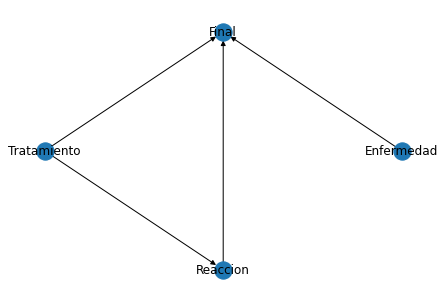

<Figure size 432x288 with 0 Axes>

In [17]:
COMPLETE_MODEL.save_digraph_as_img("figures/gt_graph")

## Aprendizaje

In [18]:
variables = sorted(["Tratamiento", "Reaccion", "Enfermedad", "Final"])
connection_tables = create_pij(variables, causal_order, invalid_edges)
connection_probas = dict()

connection_tables["Enfermedad->Final"] = 0.95
connection_tables["Enfermedad->Reaccion"] = 0.1
connection_tables["Reaccion->Final"] = 0.95
connection_tables["Tratamiento->Final"] = 0.95
connection_tables["Tratamiento->Reaccion"] = 0.95
for k in connection_tables:
    print(k, connection_tables[k])
    connection_probas[k] = [connection_tables[k]]
ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)

print(ebunch)
print(nodes)

Enfermedad->Final 0.95
Enfermedad->Reaccion 0.1
Reaccion->Final 0.95
Tratamiento->Final 0.95
Tratamiento->Reaccion 0.95
[('Enfermedad', 'Final'), ('Reaccion', 'Final'), ('Tratamiento', 'Reaccion')]
[]


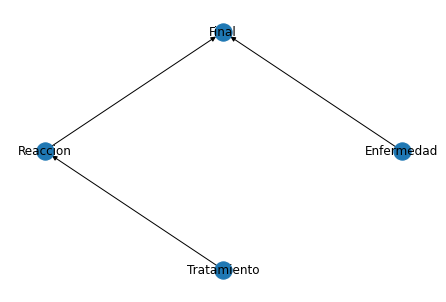

<Figure size 432x288 with 0 Axes>

In [19]:
unknown_model = deepcopy(COMPLETE_MODEL)
unknown_model.init_graph(ebunch, plot=False)
for node in nodes:
    unknown_model.digraph.add_node(node)
unknown_model.save_digraph_as_img("Nothing")
unknown_model.ebunch = ebunch
unknown_model.pgmodel = BayesianModel(ebunch)
unknown_model.pgmodel.add_nodes_from(nodes)
agent = HalfBlindAgent(nature, unknown_model)
intervention_vars = agent.model.get_intervention_variables()
target_value = 1
target = {
    "variable": agent.model.get_target_variable(),
    "value" : target_value
}
rounds = 10

### Entrenamiento

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.95
Enfermedad->Reaccion 0.1
Reaccion->Final 0.95
Tratamiento->Final 0.95
Tratamiento->Reaccion 0.95
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1)    | Reaccion(1)    |
+-------------+----------------+---------------------+-----


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+----------------+-------------------------------------+
| Final    | Enfermedad    | Tratamiento    |   phi(Final,Enfermedad,Tratamiento) |
+==========+===============+================+=====================================+
| Final(0) | Enfermedad(0) | Tratamiento(0) |                              0.1050 |
+----------+---------------+----------------+-------------------------------------+
| Final(0) | Enfermedad(0) | Tratamiento(1) |                              0.1400 |
+----------+---------------+----------------+-------------------------------------+
| Final(0) | Enfermedad(1) | Tratamiento(0) |                              0.0300 |
+----------+---------------+----------------+-------------------------------------+
| Final(0) | Enfermedad(1) | Tratamiento(1) |                              0.0675 |
+----------+---------------+----------------+-------------------------------------+
| Final(1) | Enfermedad(0) | Tratamiento(0) |                              0

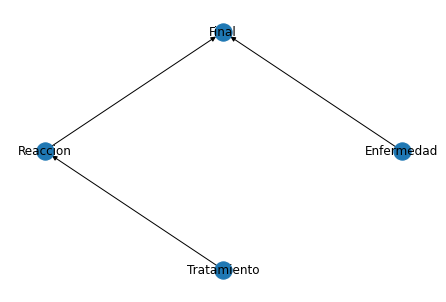

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

+---------------------------------+
Enfermedad->Final 0.39117647058823524
Enfermedad->Reaccion 0.042211055276381915
Reaccion->Final 0.475
Tratamiento->Final 0.475
Tratamiento->Reaccion 0.475
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1)    | Reaccion(1)    |
+-------------+---------


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+----------+---------------+----------------+-------------------------------------+
| Final    | Enfermedad    | Tratamiento    |   phi(Final,Enfermedad,Tratamiento) |
+==========+===============+================+=====================================+
| Final(0) | Enfermedad(0) | Tratamiento(0) |                              0.1050 |
+----------+---------------+----------------+-------------------------------------+
| Final(0) | Enfermedad(0) | Tratamiento(1) |                              0.1400 |
+----------+---------------+----------------+-------------------------------------+
| Final(0) | Enfermedad(1) | Tratamiento(0) |                              0.0300 |
+----------+---------------+----------------+-------------------------------------+
| Final(0) | Enfermedad(1) | Tratamiento(1) |                              0.0675 |
+----------+---------------+----------------+-------------------------------------+
| Final(1) | Enfermedad(0) | Tratamiento(0) |                              

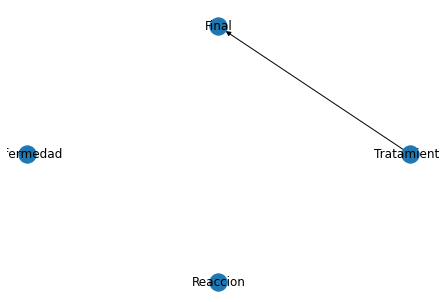

+---------------------------------+
Enfermedad->Final 0.10354671280276816
Enfermedad->Reaccion 0.006071453156191919
Reaccion->Final 0.16352459016393442
Tratamiento->Final 0.2375
Tratamiento->Reaccion 0.16352459016393442
+---------------------------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1)    | Reaccion(1)    |
+-------------+----------------+---------------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1)      | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+---------------------+----------------+--


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------+-----+
| Enfermedad(0) | 0.7 |
+---------------+-----+
| Enfermedad(1) | 0.3 |
+---------------+-----+
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
| Enfermedad  | Enfermedad(0)  | Enfermedad(0)  | Enfermedad(0)  | Enfermedad(0)  | Enfermedad(1)  | Enfermedad(1)  | Enfermedad(1)  | Enfermedad(1)  |
+-------------+----------------+----------------+----------------+----------------+----------------+-

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    | Enfermedad    | Reaccion    | Tratamiento    |   phi(Final,Enfermedad,Reaccion,Tratamiento) |
+==========+===============+=============+================+==============================================+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(0) |                                       0.1470 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(1) |                                       0.1120 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(1) | Tratamiento(0) |                                       0.0000 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion

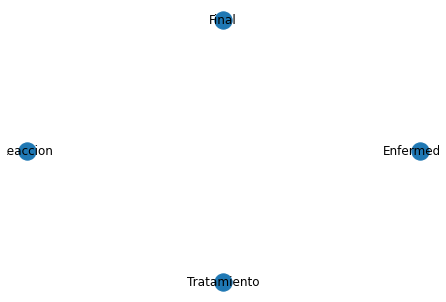

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

+---------------------------------+
Enfermedad->Final 0.027409423977203334
Enfermedad->Reaccion 0.0008732912073974678
Reaccion->Final 0.05629535071217414
Tratamiento->Final 0.11875
Tratamiento->Reaccion 0.05629535071217414
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1)    | Reaccion(


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    | Enfermedad    | Reaccion    | Tratamiento    |   phi(Final,Enfermedad,Reaccion,Tratamiento) |
+==========+===============+=============+================+==============================================+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(0) |                                       0.1470 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(1) |                                       0.1120 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(1) | Tratamiento(0) |                                       0.0000 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion

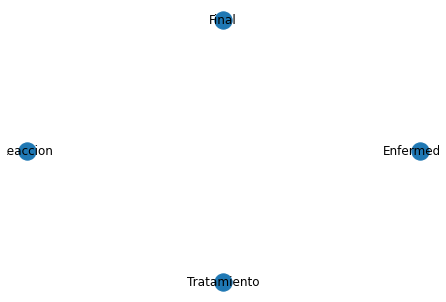

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.007255435758671471
Enfermedad->Reaccion 0.00012561037914621113
Reaccion->Final 0.01938036663861733
Tratamiento->Final 0.059375
Tratamiento->Reaccion 0.01938036663861733
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1)    | Reaccio

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    | Enfermedad    | Reaccion    | Tratamiento    |   phi(Final,Enfermedad,Reaccion,Tratamiento) |
+==========+===============+=============+================+==============================================+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(0) |                                       0.1470 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(1) |                                       0.1120 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(1) | Tratamiento(0) |                                       0.0000 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion

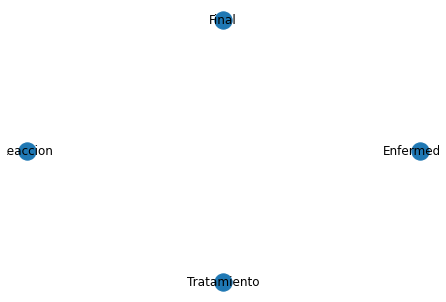

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0019205565243542132
Enfermedad->Reaccion 1.8067246315550918e-05
Reaccion->Final 0.006671929498540392
Tratamiento->Final 0.0296875
Tratamiento->Reaccion 0.006671929498540392
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1)    | Rea


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    | Enfermedad    | Reaccion    | Tratamiento    |   phi(Final,Enfermedad,Reaccion,Tratamiento) |
+==========+===============+=============+================+==============================================+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(0) |                                       0.1470 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(1) |                                       0.1120 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(1) | Tratamiento(0) |                                       0.0000 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion

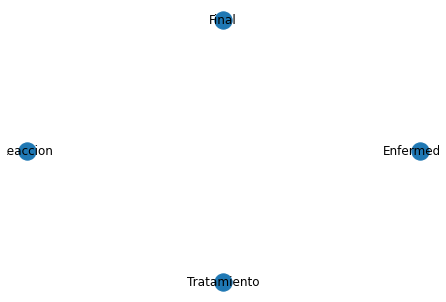

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0008767758045964887
Enfermedad->Reaccion 9.764283854360237e-06
Reaccion->Final 0.003891958874148562
Tratamiento->Final 0.014843750000000001
Tratamiento->Reaccion 0.003891958874148562
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccion(1

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    | Enfermedad    | Reaccion    | Tratamiento    |   phi(Final,Enfermedad,Reaccion,Tratamiento) |
+==========+===============+=============+================+==============================================+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(0) |                                       0.1470 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(1) |                                       0.1120 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(1) | Tratamiento(0) |                                       0.0000 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion

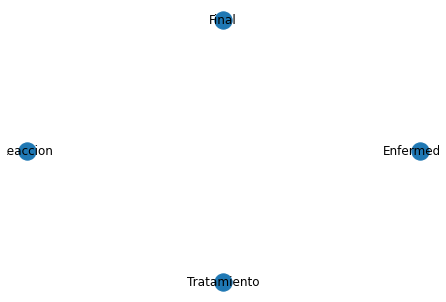

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

+---------------------------------+
Enfermedad->Final 0.0002320877129814235
Enfermedad->Reaccion 1.404451787270993e-06
Reaccion->Final 0.0013398546943790132
Tratamiento->Final 0.0074218750000000005
Tratamiento->Reaccion 0.0013398546943790132
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reaccio

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    | Enfermedad    | Reaccion    | Tratamiento    |   phi(Final,Enfermedad,Reaccion,Tratamiento) |
+==========+===============+=============+================+==============================================+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(0) |                                       0.1470 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(0) | Tratamiento(1) |                                       0.1120 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion(1) | Tratamiento(0) |                                       0.0000 |
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final(0) | Enfermedad(0) | Reaccion

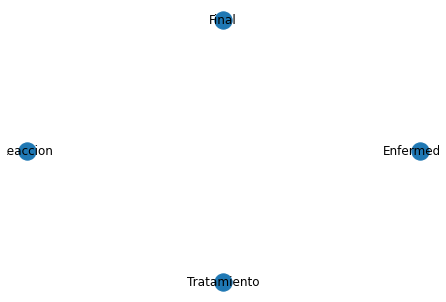

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

+---------------------------------+
Enfermedad->Final 6.143498284802387e-05
Enfermedad->Reaccion 2.0201018858007433e-07
Reaccion->Final 0.00046126145216326687
Tratamiento->Final 0.0037109375000000003
Tratamiento->Reaccion 0.00046126145216326687
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reac


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



P(Tratamiento->Final)= P(Tratamiento->Final) * P({'Enfermedad': 0, 'Tratamiento': 0, 'Reaccion': 0, 'Final': 0} | ['Enfermedad', 'Final', 'Tratamiento', 'Reaccion']) / (P({'Enfermedad': 0, 'Tratamiento': 0, 'Reaccion': 0, 'Final': 0} | ['Enfermedad', 'Final', 'Tratamiento', 'Reaccion']) + P({'Enfermedad': 0, 'Tratamiento': 0, 'Reaccion': 0, 'Final': 0} | ['Enfermedad', 'Final', 'Tratamiento', 'Reaccion']))
0.0037109375000000003 * 0.147 / 0.147 + 0.147
0.0018554687500000001
UPDATING Tratamiento->Reaccion
['Reaccion']
+---------------+-----+
| Enfermedad(0) | 0.7 |
+---------------+-----+
| Enfermedad(1) | 0.3 |
+---------------+-----+
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+----------------+----------------+
| Enfermedad  | Enfermedad(0)  | Enfermedad(0)  | Enfermedad(1)  | Enfermedad(1)  |
+-------------+----------------+----------------+---------------

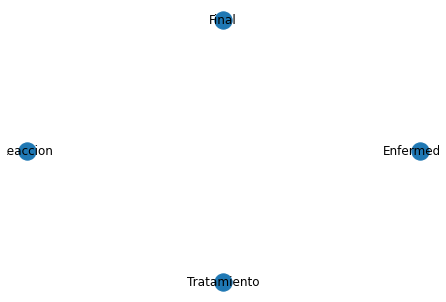

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

+---------------------------------+
Enfermedad->Final 2.804640521322829e-05
Enfermedad->Reaccion 1.0917462397526074e-07
Reaccion->Final 0.00026906918042857235
Tratamiento->Final 0.0018554687500000001
Tratamiento->Reaccion 0.00026906918042857235
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
UPDATING Enfermedad->Final
['Enfermedad']
+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+
| Reaccion(0) | 0.7            | 0.4            |
+-------------+----------------+----------------+
| Reaccion(1) | 0.3            | 0.6            |
+-------------+----------------+----------------+
+-------------+----------------+---------------------+----------------+----------------+
| Reaccion    | Reaccion(0)    | Reaccion(0)         | Reac


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+----------------+-----+
| Tratamiento(0) | 0.5 |
+----------------+-----+
| Tratamiento(1) | 0.5 |
+----------------+-----+
+-------------+----------------+----------------+----------------+----------------+
| Enfermedad  | Enfermedad(0)  | Enfermedad(0)  | Enfermedad(1)  | Enfermedad(1)  |
+-------------+----------------+----------------+----------------+----------------+
| Tratamiento | Tratamiento(0) | Tratamiento(1) | Tratamiento(0) | Tratamiento(1) |
+-------------+----------------+----------------+----------------+----------------+
| Final(0)    | 0.3            | 0.4            | 0.2            | 0.45           |
+-------------+----------------+----------------+----------------+----------------+
| Final(1)    | 0.7            | 0.6            | 0.8            | 0.55           |
+-------------+----------------+----------------+----------------+----------------+
+----------+---------------+-------------+----------------+----------------------------------------------+
| Final    

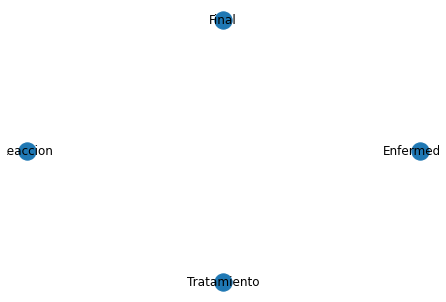

<Figure size 432x288 with 0 Axes>

In [20]:
for rnd in range(rounds):
    print("+---------------------------------+")
    for pair in connection_tables:
        print(pair, connection_tables[pair])
    print("+---------------------------------+")
    best_actions = agent.make_decision(target, intervention_vars)
    nature_response = agent.nature.action_simulator(intervention_vars, best_actions)
    agent.rewards_per_round.append(nature_response[target["variable"]])
    for var in nature_response:
        print("{} = {}".format(var, nature_response[var]))
    connection_tables = update_connection_beliefs(variables, connection_tables, COMPLETE_MODEL)
    for k in connection_tables:
        connection_probas[k] += [connection_tables[k]]
    ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)
    unknown_model.init_graph(ebunch, plot=False)
    for node in nodes:
        unknown_model.digraph.add_node(node)
    unknown_model.save_digraph_as_img("Nothing")
    unknown_model.ebunch = ebunch
    unknown_model.pgmodel = BayesianModel(ebunch)
    unknown_model.pgmodel.add_nodes_from(nodes)
    agent = HalfBlindAgent(nature, unknown_model)

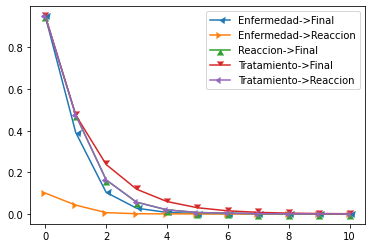

In [21]:
plot_probabilities(connection_probas)